In [1]:
import scvi
import scrnatools as rna
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set_context("paper")
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False

Data paths

In [3]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [4]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

In [5]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs.h5ad")
model = scvi.model.SCVI.load(f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/combined_all_genes", adata=adata)

INFO     File /mnt/iacchus/joe/processed_data//Fezf2_thymus_paper/scVI_models/combined_all_genes/model.pt already  
         downloaded                                                                                                


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [61]:
fezf2_regulated_genes = [
    "Ttr", "Krt10", "Resp18", "Fabp9", "Apoc3", "Csrnp3", "Klk1b16",
    "C530008M17Rik", "Maoa", "Smtnl1", "Calb1", "Cd177", "Timd2",
    "Pck1", "Nol4", "Bbox1"
]
fezf2_regulated_genes = [i for i in fezf2_regulated_genes if i in adata.var_names]

In [52]:
TFs = list(pd.read_csv("../mouse_ensemble_tfs_from_lambertetal_isyes.unique.csv", header=None)[1])
TFs = [i for i in TFs if i in adata.var_names]

# Cell type specific

## Aire KO

In [7]:
all_genes_Aire_KO = {}
filtered_genes_Aire_KO = {}

for cell_type in adata.obs.majority_voting.unique():
    subset_data = adata[adata.obs.majority_voting == cell_type]
    print(cell_type)
    de_genes = model.differential_expression(
        adata=subset_data,
        groupby="genotype",
        group1="WT",
        group2="Aire_KO"
    )
    de_genes_filtered = de_genes[de_genes.bayes_factor > 2.75]
    de_genes_filtered = de_genes_filtered[(de_genes_filtered.non_zeros_proportion1 > 0.05) | (de_genes_filtered.non_zeros_proportion2 > 0.05)]
    de_genes_filtered = de_genes_filtered[(de_genes_filtered.lfc_mean > 1) | (de_genes_filtered.lfc_mean < -1)]
    
    # Filter genes with low average normalized expression
    expressionFiltered = pd.DataFrame(
        pd.DataFrame(
            adata[:, de_genes_filtered.index].layers["scVI_normalized"],
            columns=de_genes_filtered.index
        ).quantile(0.99)
    )
    expressionFiltered = expressionFiltered[expressionFiltered[0.99] > 1]
    de_genes_filtered = de_genes_filtered[de_genes_filtered.index.isin(expressionFiltered.index)]
    de_genes["cell_type"] = cell_type
    de_genes_filtered["cell_type"] = cell_type
    all_genes_Aire_KO[cell_type] = de_genes
    filtered_genes_Aire_KO[cell_type] = de_genes_filtered

TA MEC
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]
Ciliated
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/conda-global-envs/repositories/scvi-tools/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


DE...: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]
Aire-stage
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:09<00:00,  9.60s/it]
Immature MEC
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]
Tuft2
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]
Skin, basal
INFO     Received view of anndata, making copy.   

In [8]:
all_genes_aire = pd.concat(all_genes_Aire_KO.values())
all_genes_aire = all_genes_aire.sort_index()
all_genes_aire["gene"] = all_genes_aire.index
all_genes_aire_max_bf = all_genes_aire.sort_values(by="bayes_factor", ascending=False).drop_duplicates('gene')

In [9]:
filtered_genes_aire = pd.concat(filtered_genes_Aire_KO.values())
filtered_genes_aire = filtered_genes_aire.sort_index()
filtered_genes_aire["gene"] = filtered_genes_aire.index
filtered_genes_aire_max_bf = filtered_genes_aire.sort_values(by="bayes_factor", ascending=False).drop_duplicates('gene')

In [10]:
all_genes_aire_max_bf.loc[filtered_genes_aire_max_bf.index, "lfc_mean"] = filtered_genes_aire_max_bf.lfc_mean

In [11]:
sum(filtered_genes_aire_max_bf.lfc_mean>0)

680

In [12]:
sum(filtered_genes_aire_max_bf.lfc_mean<0)

55

In [13]:
filtered_genes_aire[filtered_genes_aire.index.isin(fezf2_regulated_genes)]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2,cell_type,gene
Apoc3,0.9536,0.0464,3.022945,0.000334,0.000221,0.0,0.25,1.539678,1.659420,3.649716,...,0.352505,0.178082,5.780754,3.171355,True,WT vs Aire_KO,WT,Aire_KO,Gut/Liver,Apoc3
Apoc3,0.9612,0.0388,3.209762,0.000068,0.000014,0.0,0.25,2.790302,2.946444,2.052696,...,0.161662,0.028913,0.546920,0.064314,True,WT vs Aire_KO,WT,Aire_KO,Aire-stage,Apoc3
Fabp9,0.9486,0.0514,2.915349,0.000135,0.000051,0.0,0.25,1.598086,1.616701,3.088704,...,0.239504,0.108596,2.254973,0.642507,True,WT vs Aire_KO,WT,Aire_KO,Aire-stage,Fabp9
Klk1b16,0.9462,0.0538,2.867180,0.000163,0.000066,0.0,0.25,1.505449,1.405429,3.376779,...,0.141612,0.025571,2.456223,0.426363,True,WT vs Aire_KO,WT,Aire_KO,Gut/Liver,Klk1b16
Klk1b16,0.9404,0.0596,2.758650,0.000043,0.000018,0.0,0.25,1.368417,1.402137,2.855761,...,0.081827,0.010291,0.543038,0.066463,True,WT vs Aire_KO,WT,Aire_KO,Aire-stage,Klk1b16
Klk1b16,0.9448,0.0552,2.840010,0.000082,0.000012,0.0,0.25,2.191056,2.139840,2.334766,...,0.087227,0.020408,0.786082,0.038714,True,WT vs Aire_KO,WT,Aire_KO,Mcell,Klk1b16
Krt10,0.9410,0.0590,2.769406,0.000060,0.000014,0.0,0.25,1.644764,1.507972,1.519178,...,0.238250,0.150838,0.628961,0.140542,True,WT vs Aire_KO,WT,Aire_KO,Aire-stage,Krt10
Timd2,0.9508,0.0492,2.961410,0.000012,0.000007,0.0,0.25,1.117353,1.143310,2.523978,...,0.059659,0.000000,0.069926,0.000000,True,WT vs Aire_KO,WT,Aire_KO,Ciliated,Timd2


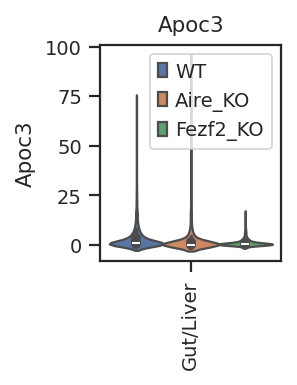

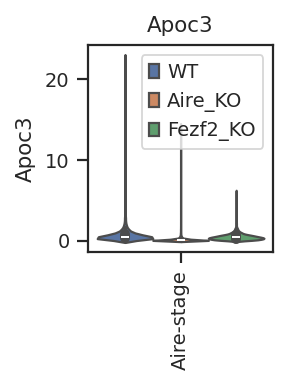

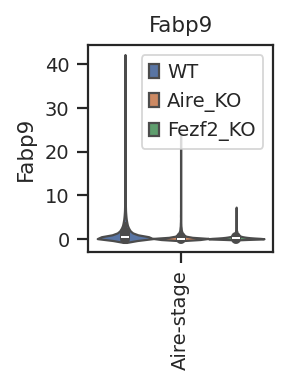

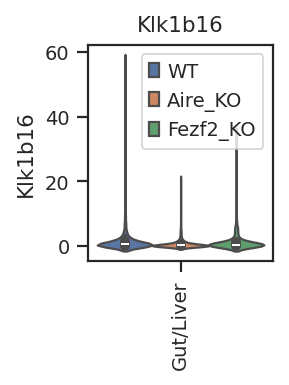

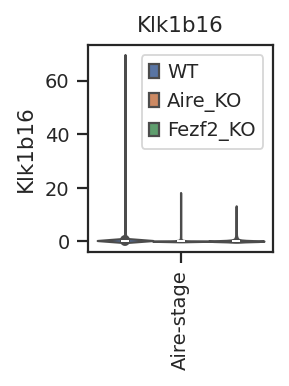

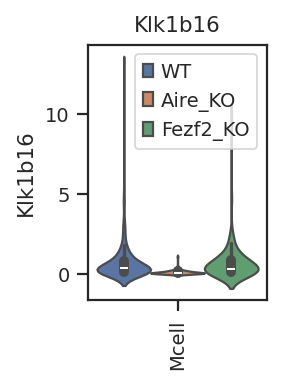

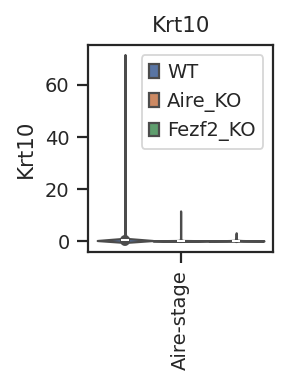

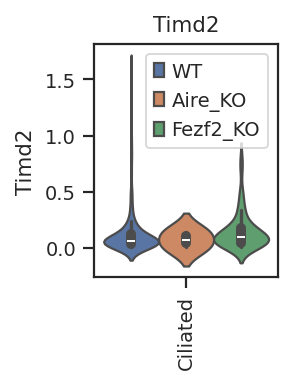

In [31]:
genes = filtered_genes_aire[filtered_genes_aire.index.isin(fezf2_regulated_genes)].index.unique()
for gene in genes:
    subset_genes = filtered_genes_aire[filtered_genes_aire.index == gene]
    for cell_type in subset_genes.cell_type.unique():
        rna.pl.gene_violinplot(
            adata,
            gene_list=[gene],
            x_key="majority_voting",
            x_values=[cell_type],
            hue_key="genotype",
            layer="scVI_normalized",
            # legend=False
        )

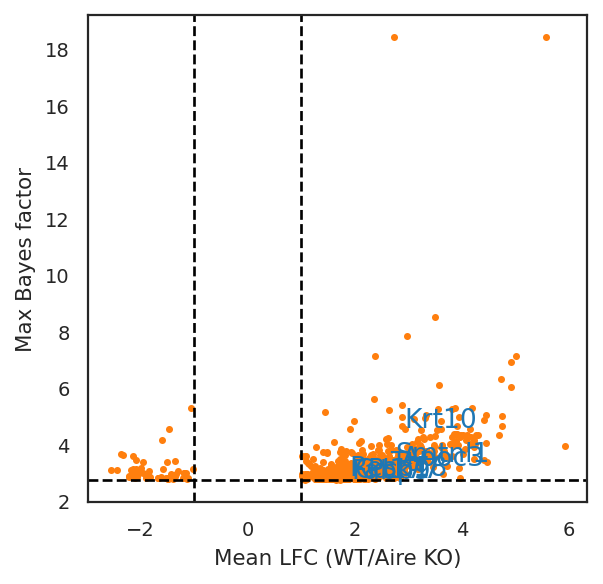

In [46]:
sns.scatterplot(
    filtered_genes_aire_max_bf,
    x="lfc_mean",
    y="bayes_factor",
    s=10,
    linewidth=0,
    color="tab:orange"
)
for gene in fezf2_regulated_genes:
    if gene in filtered_genes_fezf2_max_bf.index:
        plt.text(
            filtered_genes_fezf2_max_bf[filtered_genes_fezf2_max_bf.index == gene].lfc_mean,
            filtered_genes_fezf2_max_bf[filtered_genes_fezf2_max_bf.index == gene].bayes_factor,
            s=gene,
            color="tab:blue",
            fontdict={"fontsize":12},
        )
plt.ylabel("Max Bayes factor")
plt.xlabel("Mean LFC (WT/Aire KO)")
plt.axvline(x=1, color="black", linestyle="--")
plt.axvline(x=-1, color="black", linestyle="--")
plt.axhline(y=2.75, color="black", linestyle="--")
plt.show()

## Fezf2 KO

In [15]:
all_genes_Fezf2_KO = {}
filtered_genes_Fezf2_KO = {}

for cell_type in adata.obs.majority_voting.unique():
    subset_data = adata[adata.obs.majority_voting == cell_type]
    print(cell_type)
    de_genes = model.differential_expression(
        adata=subset_data,
        groupby="genotype",
        group1="WT",
        group2="Fezf2_KO"
    )
    de_genes_filtered = de_genes[de_genes.bayes_factor > 2.75]
    de_genes_filtered = de_genes_filtered[(de_genes_filtered.non_zeros_proportion1 > 0.05) | (de_genes_filtered.non_zeros_proportion2 > 0.05)]
    de_genes_filtered = de_genes_filtered[(de_genes_filtered.lfc_mean > 1) | (de_genes_filtered.lfc_mean < -1)]
    
    # Filter genes with low average normalized expression
    expressionFiltered = pd.DataFrame(
        pd.DataFrame(
            adata[:, de_genes_filtered.index].layers["scVI_normalized"],
            columns=de_genes_filtered.index
        ).quantile(0.99)
    )
    expressionFiltered = expressionFiltered[expressionFiltered[0.99] > 1]
    de_genes_filtered = de_genes_filtered[de_genes_filtered.index.isin(expressionFiltered.index)]
    de_genes["cell_type"] = cell_type
    de_genes_filtered["cell_type"] = cell_type
    all_genes_Fezf2_KO[cell_type] = de_genes
    filtered_genes_Fezf2_KO[cell_type] = de_genes_filtered

TA MEC
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]
Ciliated
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/conda-global-envs/repositories/scvi-tools/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


DE...: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]
Aire-stage
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:07<00:00,  7.99s/it]
Immature MEC
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:05<00:00,  5.33s/it]
Tuft2
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]
Skin, basal
INFO     Received view of anndata, making copy.   

In [16]:
all_genes_fezf2 = pd.concat(all_genes_Fezf2_KO.values())
all_genes_fezf2 = all_genes_fezf2.sort_index()
all_genes_fezf2["gene"] = all_genes_fezf2.index
all_genes_fezf2_max_bf = all_genes_fezf2.sort_values(by="bayes_factor", ascending=False).drop_duplicates('gene')

In [17]:
filtered_genes_fezf2 = pd.concat(filtered_genes_Fezf2_KO.values())
filtered_genes_fezf2 = filtered_genes_fezf2.sort_index()
filtered_genes_fezf2["gene"] = filtered_genes_fezf2.index
filtered_genes_fezf2_max_bf = filtered_genes_fezf2.sort_values(by="bayes_factor", ascending=False).drop_duplicates('gene')

In [18]:
all_genes_fezf2_max_bf.loc[filtered_genes_fezf2_max_bf.index, "lfc_mean"] = filtered_genes_fezf2_max_bf.lfc_mean

In [19]:
sum(filtered_genes_fezf2_max_bf.lfc_mean > 0)

168

In [20]:
sum(filtered_genes_fezf2_max_bf.lfc_mean < 0)

182

In [21]:
filtered_genes_fezf2[filtered_genes_fezf2.index.isin(fezf2_regulated_genes)]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2,cell_type,gene
Apoc3,0.9624,0.0376,3.242426,0.000365,0.000044,0.0,0.25,2.882977,2.969554,2.227908,...,0.498442,0.049505,4.738926,0.154584,True,WT vs Fezf2_KO,WT,Fezf2_KO,Mcell,Apoc3
Cd177,0.9446,0.0554,2.836182,0.000440,0.000111,0.0,0.25,1.993219,2.094615,2.225745,...,0.498123,0.158879,5.537385,1.381229,True,WT vs Fezf2_KO,WT,Fezf2_KO,Neuroendocrine,Cd177
Fabp9,0.9418,0.0582,2.783907,0.000346,0.000090,0.0,0.25,1.945580,1.919751,1.682114,...,0.193146,0.009901,3.947309,0.005594,True,WT vs Fezf2_KO,WT,Fezf2_KO,Mcell,Fabp9
Fabp9,0.9416,0.0584,2.780265,0.000318,0.000073,0.0,0.25,2.138161,2.107368,2.259092,...,0.345969,0.103275,6.186324,0.449617,False,WT vs Fezf2_KO,WT,Fezf2_KO,Gut/Liver,Fabp9
Krt10,0.9900,0.0100,4.595119,0.001397,0.000172,0.0,0.25,2.934834,3.012079,1.070397,...,0.671429,0.219178,16.070723,1.107292,True,WT vs Fezf2_KO,WT,Fezf2_KO,"Skin, keratinized",Krt10
Krt10,0.9456,0.0544,2.855455,0.000171,0.000027,0.0,0.25,2.294639,2.307167,1.981830,...,0.304177,0.208453,1.602050,0.143845,True,WT vs Fezf2_KO,WT,Fezf2_KO,"Lung, basal",Krt10
Krt10,0.9682,0.0318,3.415972,0.001811,0.000258,0.0,0.25,2.787375,2.920166,1.793929,...,0.757903,0.329545,23.956461,3.025089,True,WT vs Fezf2_KO,WT,Fezf2_KO,"Skin, basal",Krt10
Pck1,0.9440,0.0560,2.824774,0.000034,0.000006,0.0,0.25,2.228689,2.268631,2.064130,...,0.063042,0.001921,0.134305,0.002212,True,WT vs Fezf2_KO,WT,Fezf2_KO,"Lung, basal",Pck1
Resp18,0.9484,0.0516,2.911254,0.000666,0.000186,0.0,0.25,1.909106,1.853259,1.403482,...,0.710889,0.467290,9.632929,1.815159,True,WT vs Fezf2_KO,WT,Fezf2_KO,Neuroendocrine,Resp18
Smtnl1,0.9672,0.0328,3.383976,0.000290,0.000036,0.0,0.25,2.755314,2.705832,1.646331,...,0.535948,0.136020,3.480463,0.275255,True,WT vs Fezf2_KO,WT,Fezf2_KO,Gut/Liver,Smtnl1


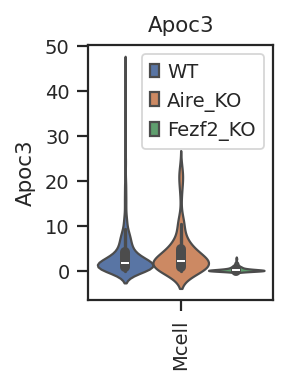

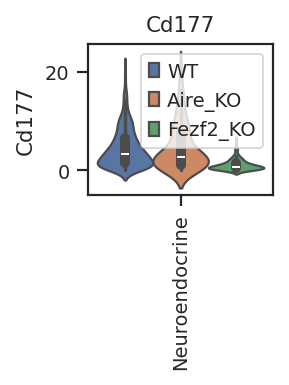

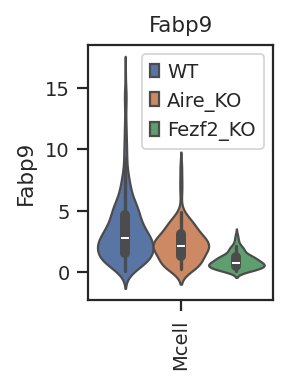

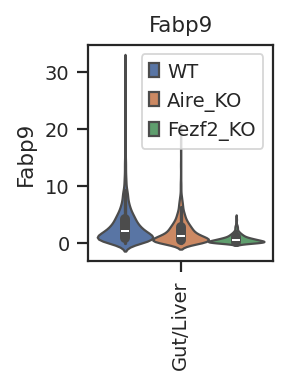

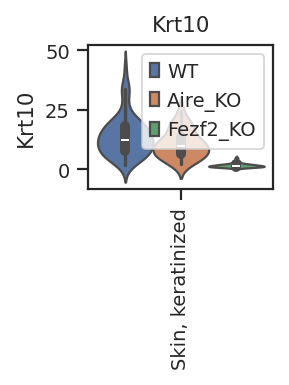

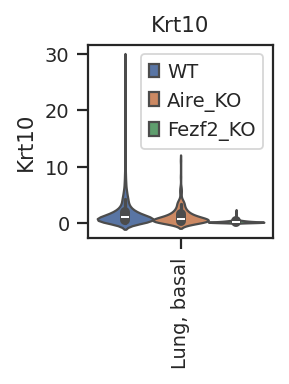

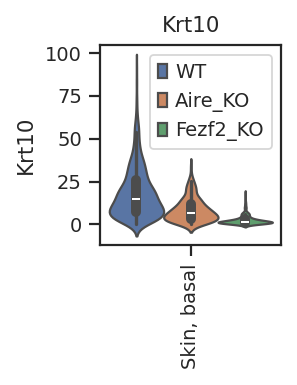

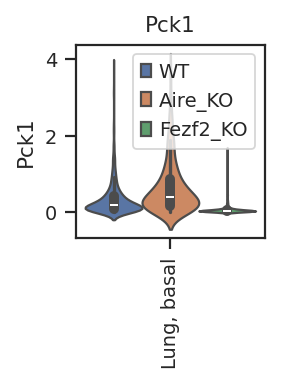

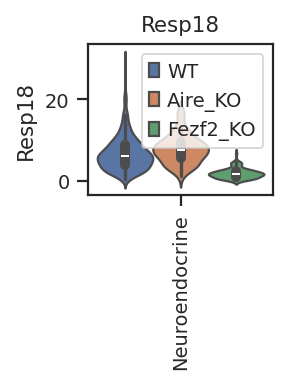

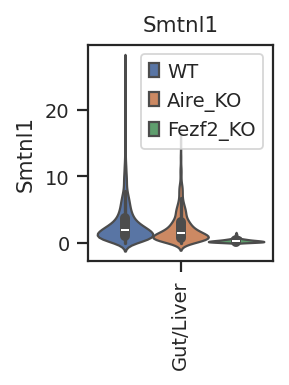

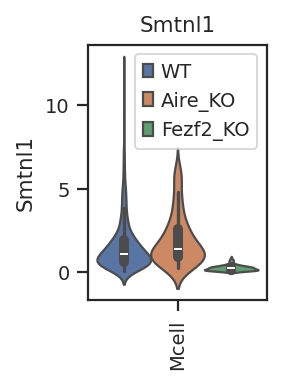

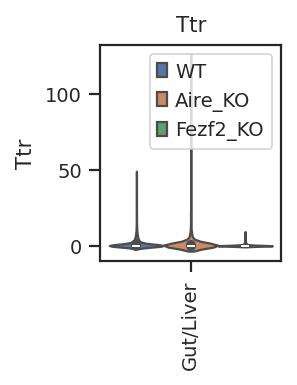

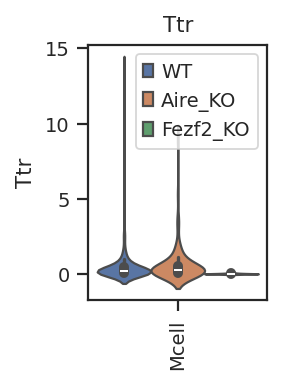

In [30]:
genes = filtered_genes_fezf2[filtered_genes_fezf2.index.isin(fezf2_regulated_genes)].index.unique()
for gene in genes:
    subset_genes = filtered_genes_fezf2[filtered_genes_fezf2.index == gene]
    for cell_type in subset_genes.cell_type.unique():
        rna.pl.gene_violinplot(
            adata,
            gene_list=[gene],
            x_key="majority_voting",
            x_values=[cell_type],
            hue_key="genotype",
            layer="scVI_normalized",
            # legend=False
        )

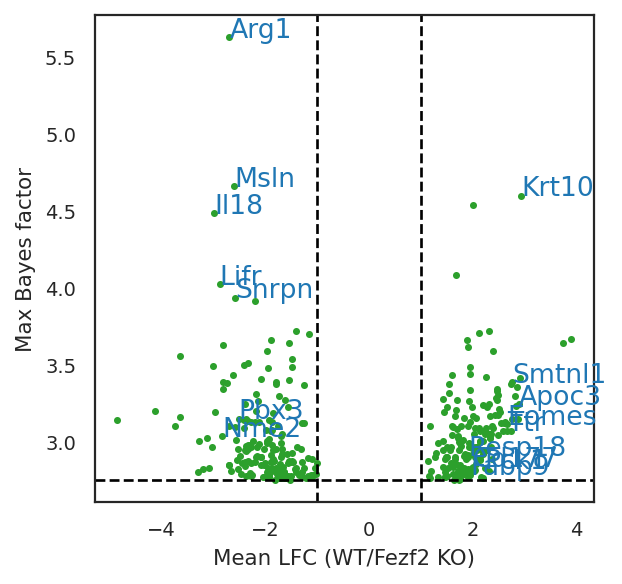

In [63]:
label_genes = fezf2_regulated_genes.copy()
label_genes += ["Arg1", "Msln", "Il18", "Lifr", "Snrpn", "Nme2", "Eomes", "Pbx3"]

sns.scatterplot(
    filtered_genes_fezf2_max_bf,
    x="lfc_mean",
    y="bayes_factor",
    s=10,
    linewidth=0,
    color="tab:green"
)
for gene in label_genes:
    if gene in filtered_genes_fezf2_max_bf.index:
        plt.text(
            filtered_genes_fezf2_max_bf[filtered_genes_fezf2_max_bf.index == gene].lfc_mean,
            filtered_genes_fezf2_max_bf[filtered_genes_fezf2_max_bf.index == gene].bayes_factor,
            s=gene,
            color="tab:blue",
            fontdict={"fontsize":12},
        )
plt.ylabel("Max Bayes factor")
plt.xlabel("Mean LFC (WT/Fezf2 KO)")
plt.axvline(x=1, color="black", linestyle="--")
plt.axvline(x=-1, color="black", linestyle="--")
plt.axhline(y=2.75, color="black", linestyle="--")
plt.show()

In [56]:
Fezf2_regulated_TFs = filtered_genes_fezf2[filtered_genes_fezf2.index.isin(TFs)]
Fezf2_regulated_TFs

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2,cell_type,gene
Atf5,0.9410,0.0590,2.769406,0.000103,0.000041,0.0,0.25,1.321674,1.320446,0.758556,...,0.626577,0.442930,1.188567,0.405861,False,WT vs Fezf2_KO,WT,Fezf2_KO,Aire-stage,Atf5
Bach2,0.9500,0.0500,2.944439,0.000081,0.000271,0.0,0.25,-2.391740,-2.553115,1.911877,...,0.242097,0.644068,0.756706,3.631567,True,WT vs Fezf2_KO,WT,Fezf2_KO,Tuft1,Bach2
Bnc2,0.9400,0.0600,2.751535,0.000010,0.000027,0.0,0.25,-1.815059,-1.862429,2.334201,...,0.028571,0.062937,0.025274,0.066748,False,WT vs Fezf2_KO,WT,Fezf2_KO,Tuft2,Bnc2
Ebf1,0.9440,0.0560,2.824774,0.000054,0.000179,0.0,0.25,-1.954257,-2.075230,1.290380,...,0.142263,0.525424,0.408920,5.746410,True,WT vs Fezf2_KO,WT,Fezf2_KO,Tuft1,Ebf1
Eomes,0.9574,0.0426,3.112367,0.000031,0.000005,0.0,0.25,2.659035,2.586585,2.217295,...,0.103704,0.005038,0.228145,0.025510,True,WT vs Fezf2_KO,WT,Fezf2_KO,Gut/Liver,Eomes
Eomes,0.9572,0.0428,3.107474,0.000025,0.000005,0.0,0.25,2.345674,2.292741,1.726686,...,0.059692,0.011762,0.085955,0.010492,True,WT vs Fezf2_KO,WT,Fezf2_KO,Aire-stage,Eomes
Ets2,0.9472,0.0528,2.886999,0.000205,0.000074,0.0,0.25,1.461502,1.467253,0.861522,...,0.772262,0.560038,1.972216,0.718863,True,WT vs Fezf2_KO,WT,Fezf2_KO,"Lung, basal",Ets2
Fezf2,0.9634,0.0366,3.270420,0.000161,0.000517,0.0,0.25,-1.621075,-1.731034,1.145996,...,0.668224,0.871287,1.508349,5.066066,True,WT vs Fezf2_KO,WT,Fezf2_KO,Mcell,Fezf2
Fezf2,0.9408,0.0592,2.765809,0.000125,0.000358,0.0,0.25,-1.862379,-1.908539,2.047783,...,0.395833,0.699443,0.928012,3.299540,False,WT vs Fezf2_KO,WT,Fezf2_KO,Goblet,Fezf2
Glis3,0.9454,0.0546,2.851574,0.000009,0.000028,0.0,0.25,-1.708157,-1.732708,2.412881,...,0.089172,0.176349,0.070920,0.179626,True,WT vs Fezf2_KO,WT,Fezf2_KO,TA MEC,Glis3


# Regulated genes comparison

In [23]:
data = pd.DataFrame({"Fezf2_lfc": all_genes_fezf2_max_bf.lfc_mean, "Aire_lfc": all_genes_aire_max_bf.lfc_mean})
groups = []
for gene in data.index:
    if gene in filtered_genes_fezf2_max_bf.index and gene in filtered_genes_aire_max_bf.index:
        groups.append("both")
    elif gene in filtered_genes_fezf2_max_bf.index and gene not in filtered_genes_aire_max_bf.index:
        groups.append("Fezf2")
    elif gene in filtered_genes_aire_max_bf.index and gene not in filtered_genes_fezf2_max_bf.index:
        groups.append("Aire")
    else:
        groups.append("neither")
data["group"] = groups

In [24]:
data[data.group != "neither"].group.value_counts()

Aire     595
Fezf2    210
both     140
Name: group, dtype: int64

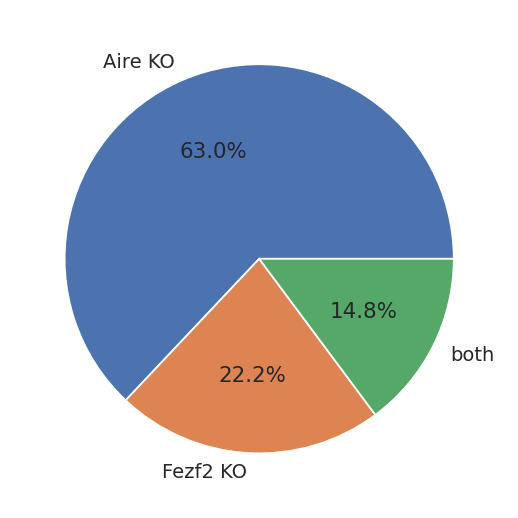

In [25]:
plt.pie(
    data[data.group != "neither"].group.value_counts(),
    labels=["Aire KO", "Fezf2 KO", "both"],
    autopct='%1.1f%%',
)
plt.show()

# Num regulated genes comparison

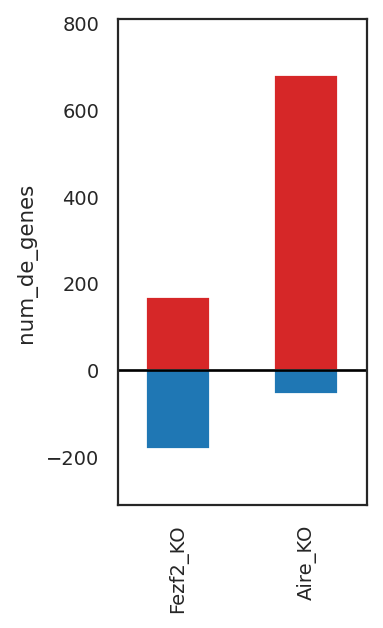

In [27]:
plotData = {}
plotData["up"] = [sum(filtered_genes_fezf2_max_bf.lfc_mean < 0), sum(filtered_genes_aire_max_bf.lfc_mean < 0)]
plotData["down"] = [sum(filtered_genes_fezf2_max_bf.lfc_mean > 0), sum(filtered_genes_aire_max_bf.lfc_mean > 0)]

plotData = pd.DataFrame(plotData, index=["Fezf2_KO", "Aire_KO"])

fig=plt.figure(figsize=(2,4))
plt.bar(x=plotData.index, height=plotData.down, color='tab:red', width=0.5)
plt.bar(x=plotData.index, height=-plotData.up, color='tab:blue', width=0.5)
plt.xticks([0,1], plotData.index, rotation='vertical')
plt.ylabel("num_de_genes")
plt.axhline(y=0, c="black")
plt.margins(0.15)
plt.show()